In [92]:
import numpy as np

In [93]:
# Example Dataset for Classification with Decision Tree
# Features: [Feature1, Feature2]
# Labels: 0 for Class A, 1 for Class B
X = np.array([[2.7, 2.5], [1.3, 1.5], [3.0, 3.7], [2.9, 2.9], 
              [7.6, 2.5], [9.0, 3.1], [7.5, 3.0], [8.1, 3.5],
])
Y = np.array([0, 0, 0, 1, 1, 1, 1, 1])

In [94]:
def entropy(y):
    """
    Calculate the entropy of a label array.
    Args:
        y (np.ndarray): Array of labels.
    """
    values, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return -np.sum(probs * np.log2(probs))

entropy(Y)

0.954434002924965

In [95]:
def information_gain(y, y_left, y_right):
    H_parent = entropy(y)
    n = len(y)
    n_left = len(y_left)
    n_right = len(y_right)

    if n_left == 0 or n_right == 0:
        return 0

    H_left = entropy(y_left)
    H_right = entropy(y_right)

    child_entropy = (n_left / n) * H_left + (n_right / n) * H_right
    info_gain = H_parent - child_entropy
    return info_gain

In [96]:
def best_split(X, y):
    """
    Find the best split for the dataset.
    Args:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Labels.
    Returns:
        best_gain (float): Best information gain.
        best_feature (int): Index of the feature to split on.
        best_threshold (float): Threshold value for the split.
    """
    best_gain = 0
    best_feature = None
    best_threshold = None

    n_features = X.shape[1]
    
    for feature in range(n_features):
        thresholds = np.unique(X[:, feature])
        
        for threshold in thresholds:
            left_mask = X[:, feature] <= threshold
            right_mask = X[:, feature] > threshold
            
            y_left = y[left_mask]
            y_right = y[right_mask]
            
            gain = information_gain(y, y_left, y_right)
            
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold

    return best_gain, best_feature, best_threshold

# Example usage
best_gain, best_feature, best_threshold = best_split(X, Y)
print(f"Best Gain: {best_gain} Feature: {best_feature} Threshold: {best_threshold}")

Best Gain: 0.5487949406953987 Feature: 0 Threshold: 3.0


In [97]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)

        if len(unique_classes) == 1 or (self.max_depth and depth >= self.max_depth):
            return unique_classes[0]

        gain, feature, threshold = best_split(X, y)
        
        if gain == 0:
            return np.random.choice(unique_classes)

        left_mask = X[:, feature] <= threshold
        right_mask = X[:, feature] > threshold

        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return (feature, threshold, left_subtree, right_subtree)

    def predict(self, X):
        return np.array([self._predict(sample) for sample in X])

    def _predict(self, sample):
        node = self.tree
        while isinstance(node, tuple):
            feature, threshold, left_subtree, right_subtree = node
            if sample[feature] <= threshold:
                node = left_subtree
            else:
                node = right_subtree
        return node
    
# Example usage of DecisionTree
tree = DecisionTree(max_depth=3)
tree.fit(X, Y)

X_test = np.array([[2.5, 2.0], [8.0, 3.0], [1.0, 1.0]])
predictions = tree.predict(X_test)
print("Predictions:", predictions)
    

Predictions: [0 1 0]


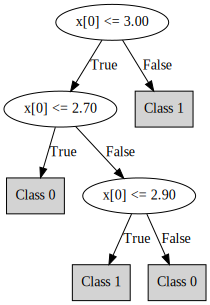

In [99]:
from graphviz import Digraph

def visualize_tree(node, dot=None, node_id=0):
    if dot is None:
        dot = Digraph()
    
    current_id = str(node_id)

    if isinstance(node, tuple):
        feature, threshold, left, right = node
        label = f"x[{feature}] <= {threshold:.2f}"
        dot.node(current_id, label)

        left_id = node_id + 1
        right_id = visualize_tree(left, dot, left_id)
        dot.edge(current_id, str(left_id), label="True")

        next_id = right_id + 1
        right_end_id = visualize_tree(right, dot, next_id)
        dot.edge(current_id, str(next_id), label="False")

        return right_end_id
    else:
        dot.node(current_id, f"Class {node}", shape='box', style='filled', fillcolor='lightgray')
        return node_id

def draw_tree(tree):
    dot = Digraph()
    visualize_tree(tree.tree, dot)
    return dot

draw_tree(tree)